# A Linear Diffusion Overland Flow Model

## Overview

This notebook demonstrates the `LinearDiffusionOverlandFlowRouter` Landlab component. The component implements a two-dimensional model of overland flow, based on a linearization of the diffusion-wave approximation of the shallow-water equations.

### Model

#### Flow direction, depth, and velocity

The diffusion-wave equations are a simplified form of the 2D shallow-water equations in which energy slope is assumed to equal water-surface slope. Conservation of water mass is expressed in terms of the time derivative of the local water depth, $H$, and the spatial derivative (divergence) of the unit discharge vector $\mathbf{q} = UH$ (where $U$ is the 2D depth-averaged velocity vector):

$$\frac{\partial H}{\partial t} + \nabla\cdot\mathbf{q} = R - I_c \left( 1 - e^{-H/H_i} \right) $$

where $R$ is the local runoff rate [L/T] and $\mathbf{q}$ has dimensions of volume flow per time per width [L$^2$/T]. The flow velocity is calculated using a linearized form of the Manning friction law:

$$\mathbf{U} = \frac{H^{4/3}}{n^2 u_c} \nabla w$$

$$w = \eta + H$$

Here $\eta(x,y,t)$ is ground-surface elevation, $w(x,y,t)$ is water-surface elevation, $n$ is the Manning friction coefficient, and $u_c$ is a characteristic scale velocity (see, e.g., Mariotti, 2018). Thus, there are two parameters governing flow speed: $n$ and $u_c$. The may, however, be treated as a single lumped parameter $n^2 u_c$.

### Numerical Methods

1. Implicit Euler:
   $$\nabla\cdot\mathbf{U}H^{n+1} = -\frac{H^{n+1}-H^n}{\tau}
   R - I_c \left( 1 - e^{-H^{n+1}/H_i} \right),\qquad
   \mathbf{U} = \frac{(H^{n+1})^{4/3}}{n^2 u_c} \nabla (H^{n+1}+w) $$
2. Linearized:
   $$\nabla\cdot\mathbf{U}H^{n} = -\frac{H^{n+1}-H^n}{\tau}
   R - I_c \left( 1 - e^{-H^{n}/H_i} \right),\qquad
   \mathbf{U} = \frac{(H^{n})^{4/3}}{n^2 u_c} \nabla (H^{n+1}+w) $$

For stability need to add artificial diffusion $\varepsilon \triangle H$

### The component

Import the needed libraries, then inspect the component's docstring:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dune.ufl
from landlab import RasterModelGrid
from landlab.io import esri_ascii

if False:
    from landlab.components.overland_flow import LinearDiffusionOverlandFlowRouter as LDOF
else:
    from dune.femdg.landlab import DuneDiffOverlandFlowSolver as LDOF

## Example 2: overland flow on a DEM

For this example, we'll import a small digital elevation model (DEM) for a site in New Mexico, USA, with 10 m cells [hugo sige](hugo_site.asc).

In [2]:
# Process parameters
n = 0.1  # roughness coefficient, (s/m^(1/3))
uc = 1.0  # characteristic velocity scale (m/s)
R1 = 72.0 / (3600.0 * 1000.0)  # initial rainfall rate, m/s (converted from mm/hr)
R2 = 0.0 / (3600.0 * 1000.0)  # later rainfall rate, m/s (converted from mm/hr)
infilt_cap = 10.0 / (3600 * 1000.0)  # infiltration capacity, m/s (converted from mm/hr)
dx = 10

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 1200.0  # duration of run, s
dt = 20.0  # time-step size, s
dem_filename = "hugo_site.asc"

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

In [3]:
# Read the DEM file as a grid with a 'topographic__elevation' field
with open(dem_filename) as fp:
    grid = esri_ascii.load(fp, name="topographic__elevation", at="node")
elev = grid.at_node["topographic__elevation"]

# Configure the boundaries: valid right-edge nodes will be open;
# all NODATA (= -9999) nodes will be closed.
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED

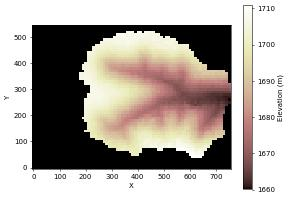

In [4]:
# display the topography
grid.imshow(elev, colorbar_label="Elevation (m)", cmap="pink")

It would be nice to track discharge at the watershed outlet, but how do we find the outlet location? We actually have several valid nodes along the right-hand edge. Then we'll keep track of the field `water__specific_discharge` at the active links that connect to these boundary nodes. We can identify the nodes by the fact that they are (a) at the right-hand edge of the grid, and (b) have positive elevations (the ones with -9999 are outside of the watershed). We can identify the relevant active links as those connected to the outlet nodes that have active status (meaning they do not connect to any closed boundary nodes).

In [5]:
indices = np.where(elev[grid.nodes_at_right_edge] > 0.0)[0]
outlet_nodes = grid.nodes_at_right_edge[indices]
print(f"Outlet nodes: {outlet_nodes}")
print(f"Elevations of the outlet nodes: {elev[outlet_nodes]}")

links_at_outlets = grid.links_at_node[outlet_nodes]
links_to_track = links_at_outlets[
    grid.status_at_link[links_at_outlets] == grid.BC_LINK_IS_ACTIVE
].flatten()
print(f"Links at which to track discharge: {links_to_track}")

Outlet nodes: [1975 2051 2127 2203 2279 2355 2431 2507]
Elevations of the outlet nodes: [1661. 1660. 1661. 1662. 1665. 1669. 1672. 1676.]
Links at which to track discharge: [3849 4000 4151 4302 4453 4604 4755 4906]


In [6]:
# Instantiate the component
olflow = LDOF(grid, infilt_rate=infilt_cap, roughness=n)

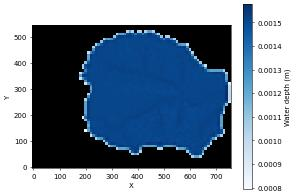

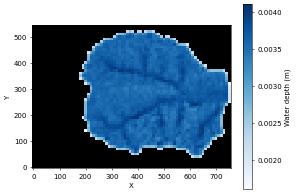

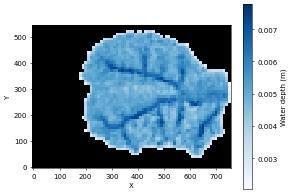

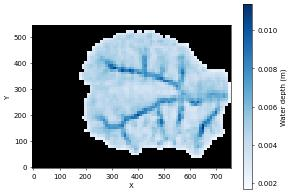

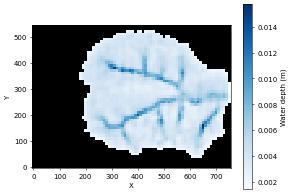

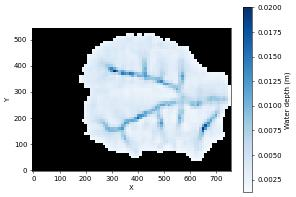

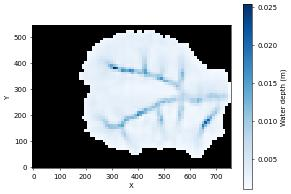

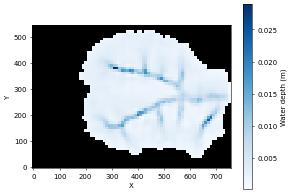

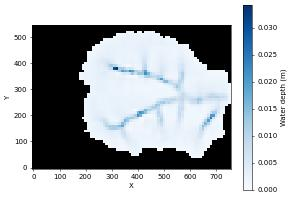

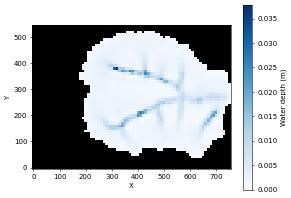

In [7]:
q = grid.at_link["water__specific_discharge"]

for i in range(num_steps):
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(q[links_to_track]) * dx
    if i%6 == 3:
        plt.figure()
        grid.imshow(
            grid.at_node["surface_water__depth"], cmap="Blues", colorbar_label="Water depth (m)"
        )

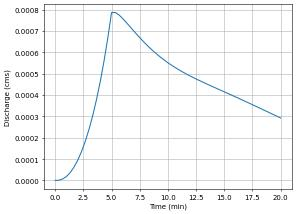

In [8]:
plt.plot(time_since_storm_start / 60.0, discharge)
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

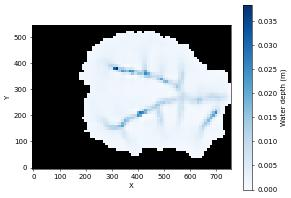

In [9]:
grid.imshow(
    grid.at_node["surface_water__depth"], cmap="Blues", colorbar_label="Water depth (m)"
)

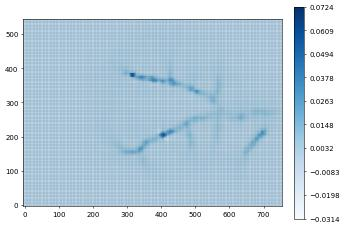

np.float64(0.0007861949065562021)

In [10]:
olflow.uh.plot(level=1,cmap="Blues",gridLines="gray")
max(discharge)

Voila! A fine hydrograph, and a water-depth map that shows deeper water in the channels (and highlights depressions and low-gradient spots in the topography).

## References

Mariotti, G. (2018). Marsh channel morphological response to sea level rise and sediment supply. Estuarine, Coastal and Shelf Science, 209, 89-101.

Press, W. H., Vetterling, W. T., Teukolsky, S. A., & Flannery, B. P. (1986). Numerical recipes. Cambridge: Cambridge university press.

Slingerland, R., & Kump, L. (2011). Mathematical Modeling of Earth's Dynamical Systems. Princeton University Press.